In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']
model_name = mydict['model_name']

In [3]:
# minimum generated 
segments[segments.segment=='generated'].length.min()

4

### classifier - generated with maxp/shape/entropy features

In [4]:
mm.run.max()

9

In [5]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [6]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

10

In [7]:
# check that there are no nulls in generated
mm[(mm.segment=='generated')].isna().sum()

run                      0
pid                      0
tok                      0
area                     0
shape                    0
true_ent                 0
maxp                     0
trans_s                  0
trans_l                  0
logitlens_kl             0
logitlens_iou       375632
start                    0
end                      0
segment                  0
seq                      0
length                   0
tok_rel_segm             0
tok_rel_segm_abs         0
tokzero                  0
tokzero_end              0
dtype: int64

In [8]:
mm.shape

(3720338, 20)

In [9]:
%%time

# take generated 
mmg = mm[mm.segment=='generated']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded], 
                 axis=1)

mmg.shape

CPU times: user 21.6 s, sys: 557 ms, total: 22.2 s
Wall time: 22.4 s


(375632, 59)

In [10]:
%%time

# take postilla
mmp = mm[mm.segment=='postilla']

# expand logitlens kl (for generated only)
df_logitlens_kl_expanded_postilla = mmp['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded_postilla.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded_postilla.shape[1])]

mmp = pd.concat([mmp.drop(columns=['logitlens_kl', 'logitlens_iou']),
                 df_logitlens_kl_expanded_postilla], 
                 axis=1)

mmp.shape

CPU times: user 3.77 s, sys: 108 ms, total: 3.88 s
Wall time: 3.91 s


(84189, 59)

In [11]:
%%time

# multiply fishes

runs = pd.DataFrame({"run": range(10)}) 
mmp = mmp.drop(columns=['run']) # only run 0
mmp_e = runs.merge(mmp, how="cross")

mmp_e.shape[0] == 10 * mmp.shape[0]

CPU times: user 92.9 ms, sys: 79.9 ms, total: 173 ms
Wall time: 172 ms


True

In [12]:
# reconstructed vectors for postilla and generated (half a GB)
mmg = pd.concat([mmg, mmp_e], axis=0).sort_values(["run", "pid", "tok"])

In [13]:
# df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
# df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
#mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
#                     df_logitlens_kl_expanded,
#                     df_logitlens_iou_expanded], axis=1)

In [14]:
%%time

# beginning of generation
N = 10

selected_features = ['shape', 'true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

# WARNING: pivoting will generate null values if N < min generated length
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

CPU times: user 109 ms, sys: 25.6 ms, total: 134 ms
Wall time: 145 ms


In [15]:
ds.correct.value_counts()

correct
True     11243
False     3527
Name: count, dtype: int64

In [16]:
ds.shape

(14770, 34)

In [17]:
# WARNING here we are dropping duplicates (and cases where |generated| < N)
ds = ds.dropna().drop_duplicates(ds.columns[1:-1])

In [18]:
ds.shape

(3032, 34)

In [19]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [20]:
X.loc[:,X.nunique()!=1].shape

(3032, 30)

In [21]:
X.isnull().sum().sum() == 0

True

In [22]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

In [23]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [24]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

pred_proba_generated = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 9.31 s, sys: 5.71 s, total: 15 s
Wall time: 4.08 s


In [25]:
pred = pred_proba_generated.argmax(axis=1).astype(bool)
print(classification_report(y_res_generated.values, pred))

              precision    recall  f1-score   support

       False       0.68      0.72      0.70      1005
        True       0.86      0.83      0.84      2027

    accuracy                           0.79      3032
   macro avg       0.77      0.77      0.77      3032
weighted avg       0.80      0.79      0.79      3032



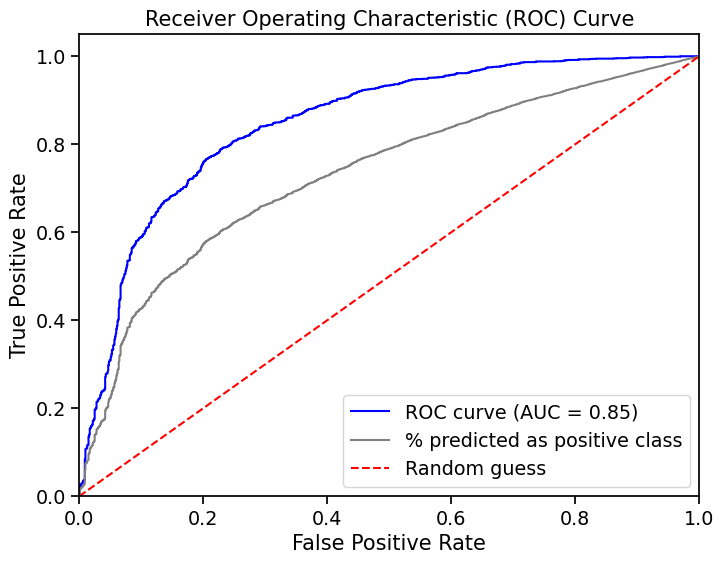

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / len(y_res_generated.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 9.89 s, sys: 1.69 s, total: 11.6 s
Wall time: 8.46 s


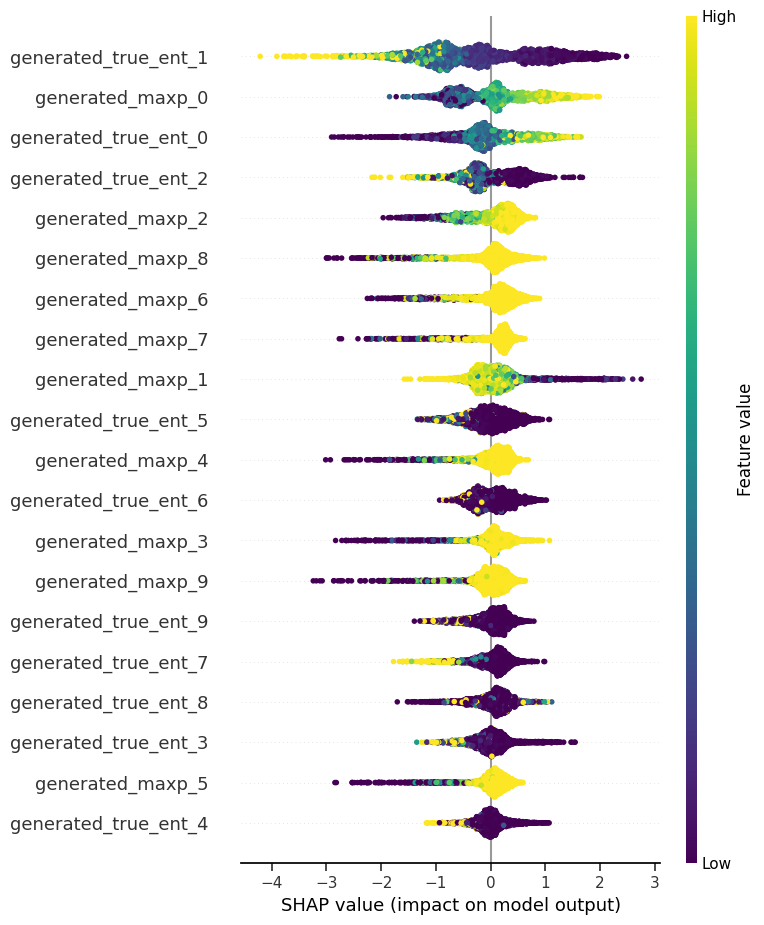

In [28]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [29]:
# shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [30]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [31]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [32]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.481570
generated_shape_       0.007832
generated_true_ent_    0.510598
Name: value, dtype: float64

In [33]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

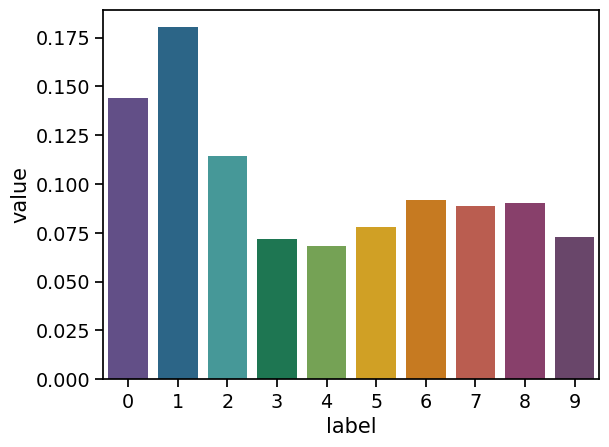

In [34]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

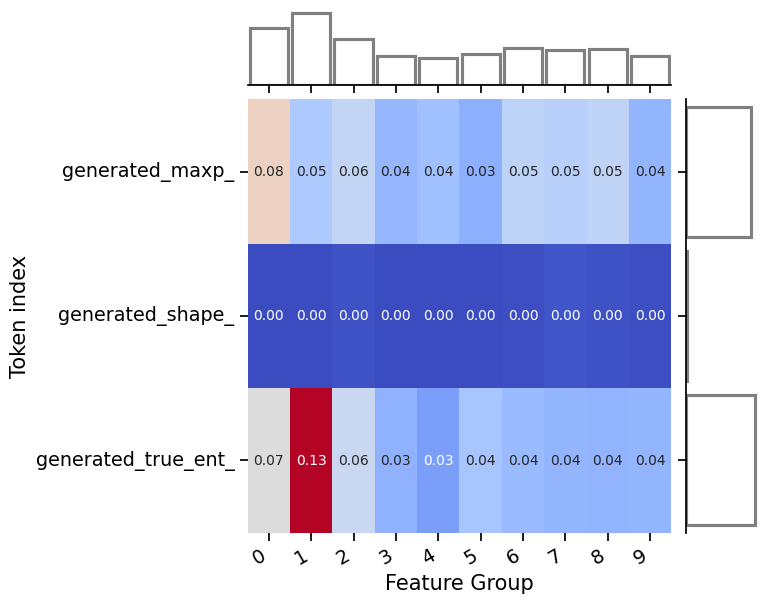

In [35]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### generated with all features

In [36]:
%%time

# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated_all = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 320 ms, sys: 78.7 ms, total: 398 ms
Wall time: 372 ms


In [37]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_all = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 1min 41s, sys: 21.1 s, total: 2min 2s
Wall time: 31 s


In [38]:
y_res_generated.shape, y_res_generated_all.shape

((3032,), (5274,))

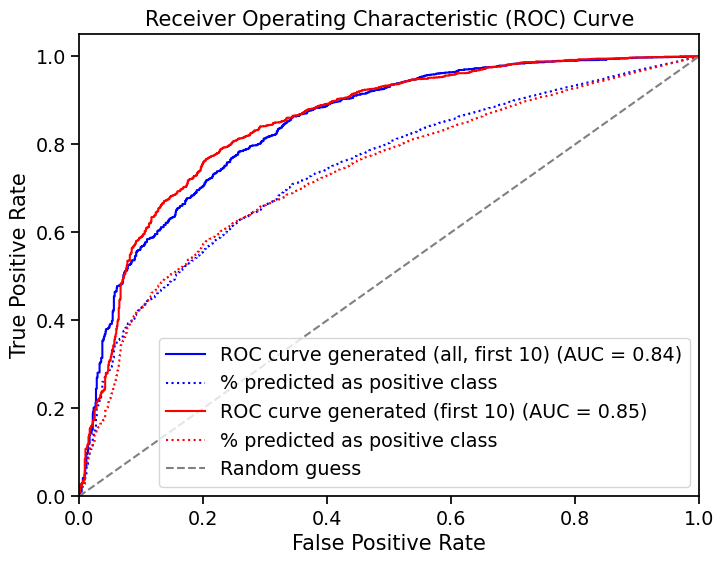

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_generated_all.values, pred_proba_all[:, 1])
true_counts_rel = [(pred_proba_all[:, 1] > thr).sum() / pred_proba_all.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve generated (all, first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

 98%|===================| 5147/5274 [00:16<00:00]        

CPU times: user 24.2 s, sys: 2.37 s, total: 26.5 s
Wall time: 18.7 s


grp
generated_logitlens_kl_    0.849104
generated_maxp_            0.074908
generated_true_ent_        0.075988
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

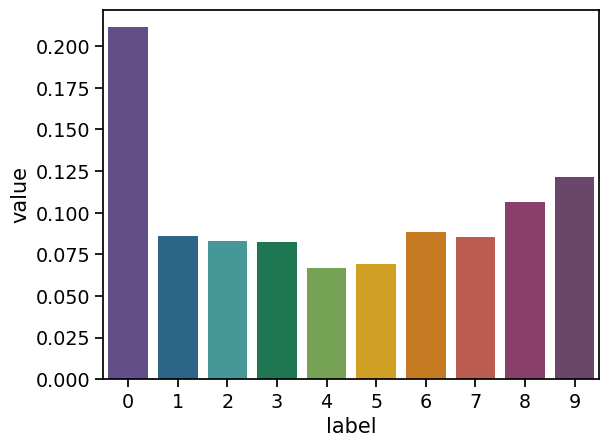

In [41]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

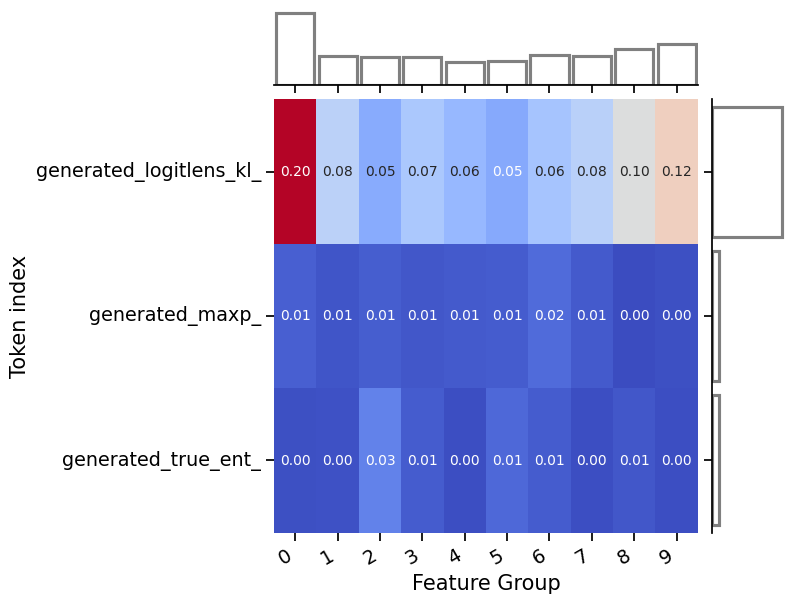

In [42]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [117]:
%%time

# beginning of generation
N = 10

selected_features = list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated_kl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 228 ms, sys: 86.6 ms, total: 315 ms
Wall time: 315 ms


In [123]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [124]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

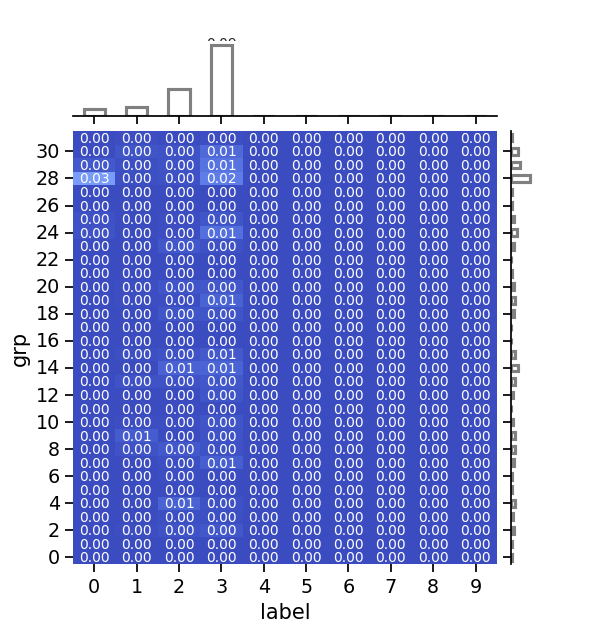

In [125]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [126]:
# for later use
besties = list(vals.sort_values('value', ascending=False)[:10].label_orig)
besties

['generated_logitlens_kl40_2',
 'generated_logitlens_kl39_3',
 'generated_logitlens_kl38_3',
 'generated_logitlens_kl34_3',
 'generated_logitlens_kl33_3',
 'generated_logitlens_kl35_3',
 'generated_logitlens_kl40_3',
 'generated_logitlens_kl28_0',
 'generated_logitlens_kl28_3',
 'generated_logitlens_kl38_1']

### postilla

In [47]:
mm[(mm.segment=='postilla')].tokzero.max()

56

In [221]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]
y_res_postilla = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

(1477, 175)


In [222]:
y_res_postilla.shape, y_res_generated.shape

((1477,), (3032,))

In [223]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 16.6 s, sys: 7.57 s, total: 24.1 s
Wall time: 5.33 s


In [224]:
pred = pred_proba_postilla.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla.values, pred))

              precision    recall  f1-score   support

       False       0.45      0.50      0.47       364
        True       0.83      0.80      0.81      1113

    accuracy                           0.72      1477
   macro avg       0.64      0.65      0.64      1477
weighted avg       0.74      0.72      0.73      1477



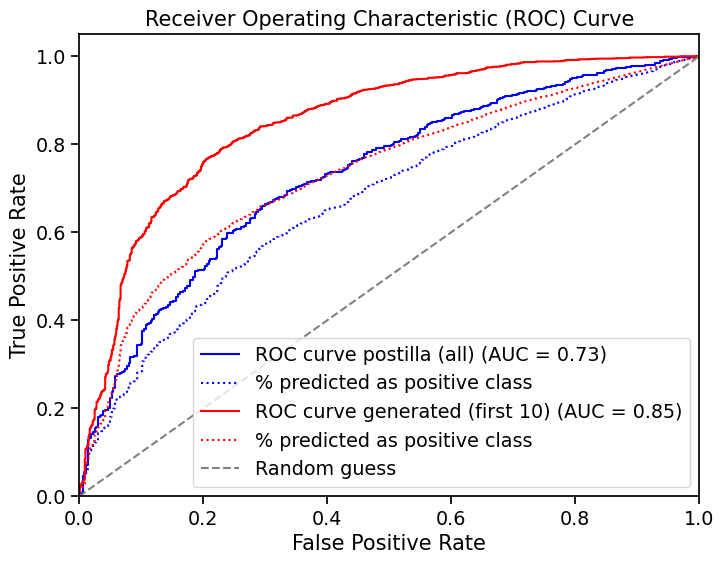

In [225]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [226]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

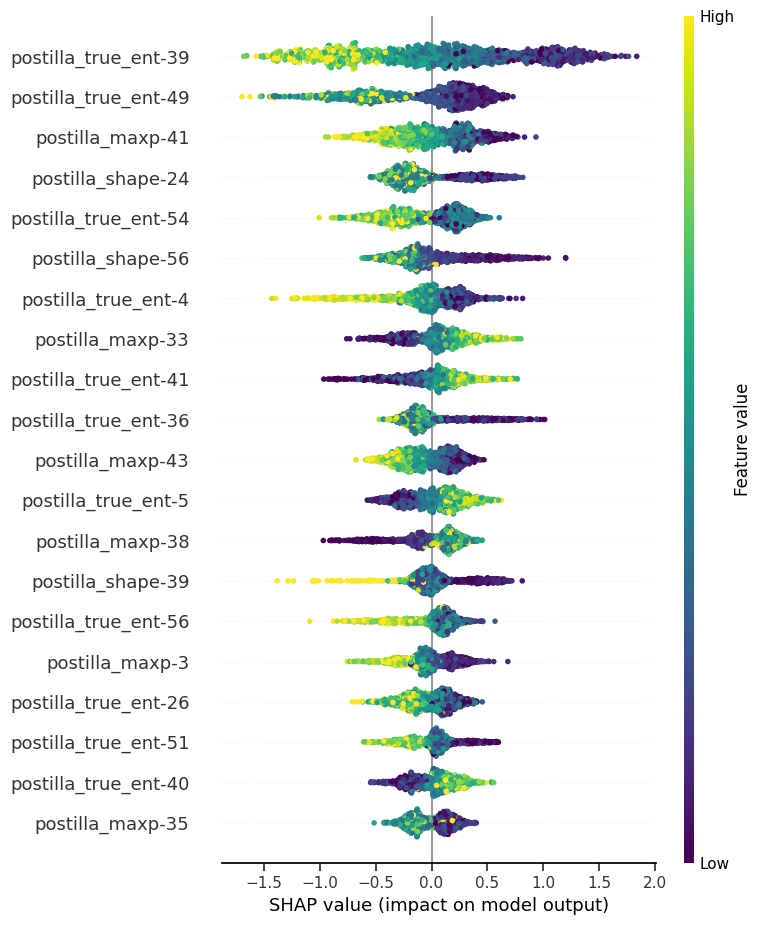

In [227]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [228]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [229]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [230]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.2494576473059776

In [231]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.314747
postilla_shape-       0.161131
postilla_true_ent-    0.524121
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



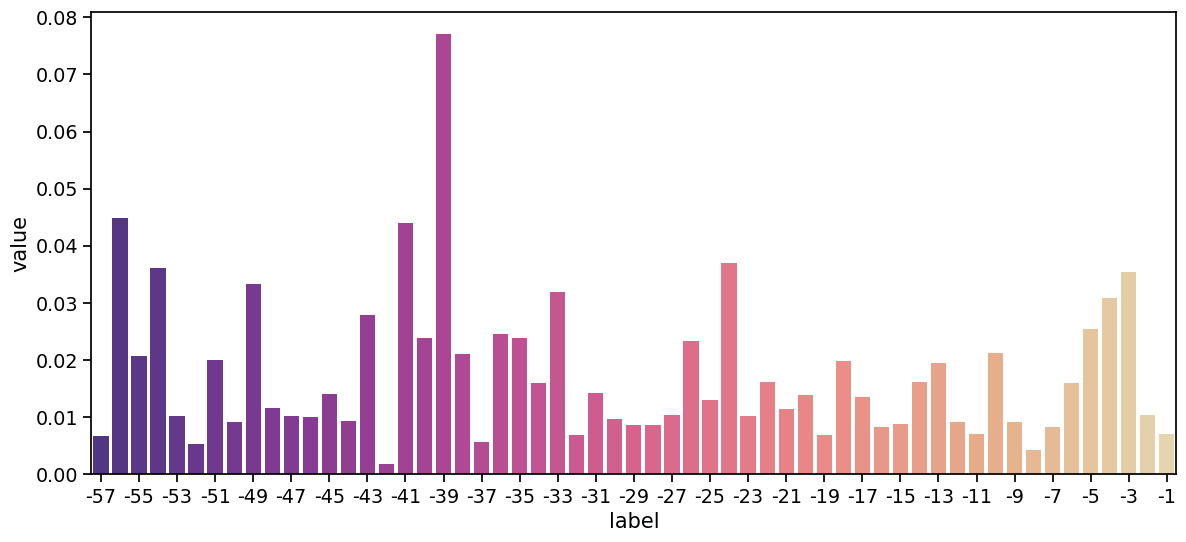

In [59]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

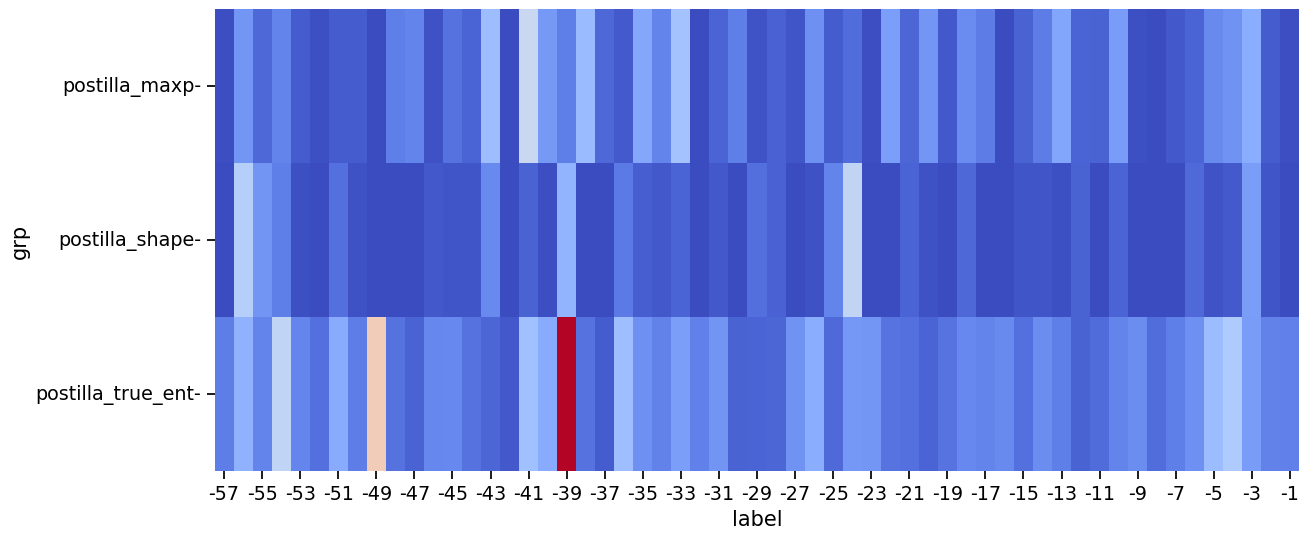

In [60]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=False, fmt=".2f", annot_kws={"fontsize":6}, cmap="coolwarm")
plt.show()

### postilla: + kl

In [211]:
# all postilla

selected_features = list(df_logitlens_kl_expanded.columns)

# reinstate this if you do not want to spill the first candidate info
# ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['true_ent', 'maxp']+selected_features).reset_index()
# ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]

# add first generated feature
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero==0)][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features ]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent'] + selected_features).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds # .merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent'] + selected_features ).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds2 = ds # .merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

ds = ds1.merge(ds2, on = ['run', 'pid'])
# ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])


############## WARNING THIS BYPASSES THE RECOVER ABOVE
# reinstate this if you do not want to spill the first candidate info
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'true_ent', 'maxp'] + selected_features]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['true_ent', 'maxp']+selected_features).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]


# indexes for kl/iou are _LAYER_TOKEN
# ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla_kl = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

In [212]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla_kl = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 2min 11s, sys: 36.9 s, total: 2min 48s
Wall time: 39 s


In [213]:
pred = pred_proba_postilla_kl.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla_kl.values, pred))

              precision    recall  f1-score   support

       False       0.50      0.53      0.51       449
        True       0.82      0.80      0.81      1203

    accuracy                           0.73      1652
   macro avg       0.66      0.67      0.66      1652
weighted avg       0.73      0.73      0.73      1652



In [214]:
y_res_postilla.shape, y_res_postilla_kl.shape, y_res_generated.shape

((1477,), (1652,), (3032,))

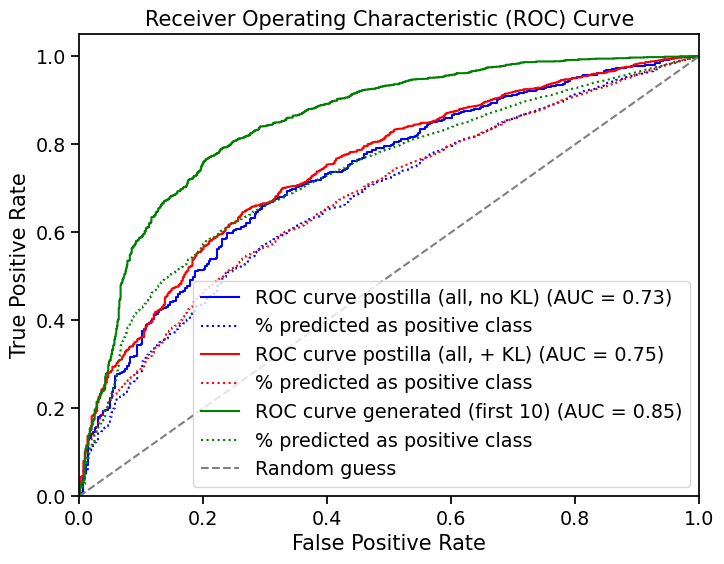

In [215]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all, no KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_postilla_kl.values, pred_proba_postilla_kl[:, 1])
true_counts_rel = [(pred_proba_postilla_kl[:, 1] > thr).sum() / pred_proba_postilla_kl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postilla (all, + KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### combo: base features generated + postilla

In [67]:
# COMBO
# beginning of generate + postilla
N = 10
ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [68]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [69]:
ds.shape, ds1.shape, ds2.shape

((1477, 208), (14770, 37), (1477, 175))

In [70]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELECT TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y
pids_res = pids[y_res.index]

In [71]:
# %%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, 
                                     method='predict_proba')

In [72]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.65      0.50      0.56       364
        True       0.85      0.91      0.88      1113

    accuracy                           0.81      1477
   macro avg       0.75      0.71      0.72      1477
weighted avg       0.80      0.81      0.80      1477



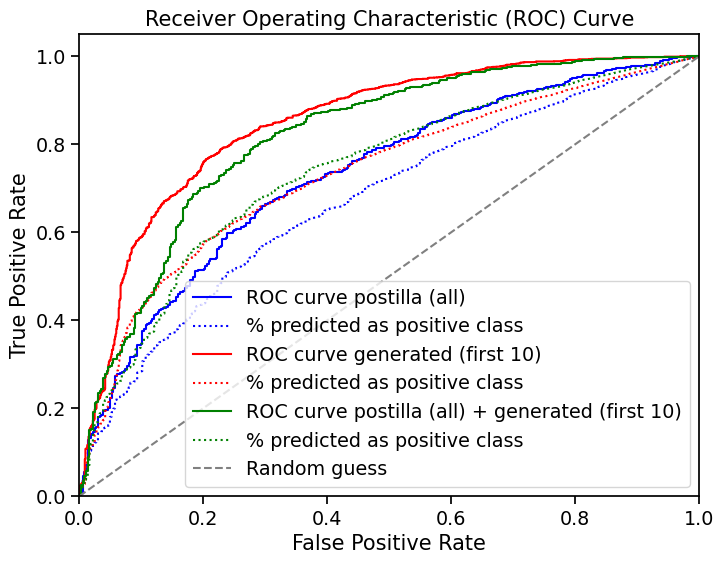

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first {N})')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [75]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [76]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.353691
generated_true_ent_    0.237944
postilla_maxp-         0.064356
postilla_shape-        0.083320
postilla_true_ent-     0.260688
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

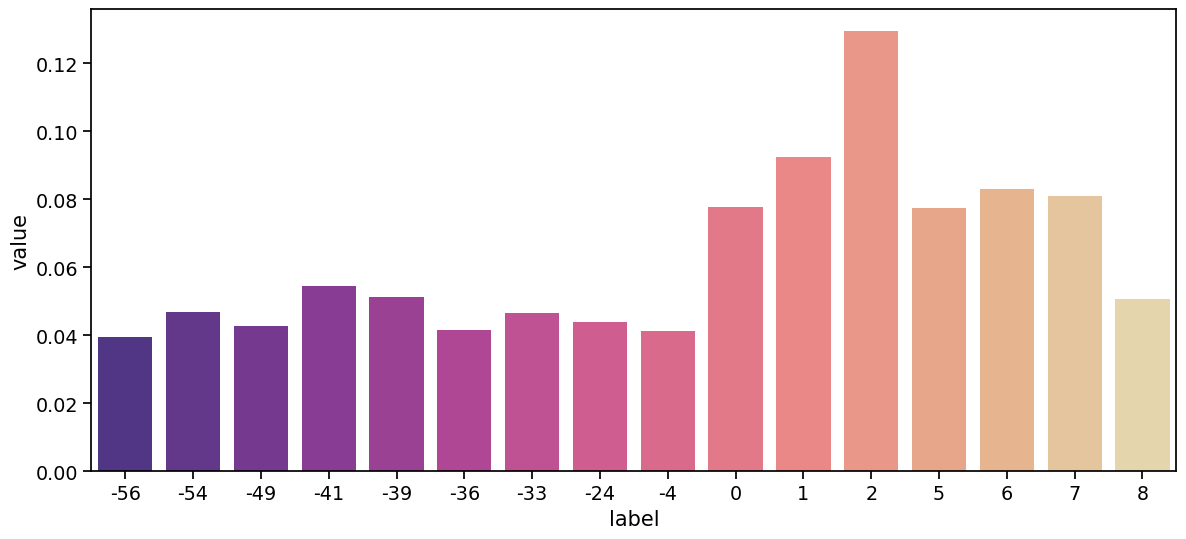

In [77]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

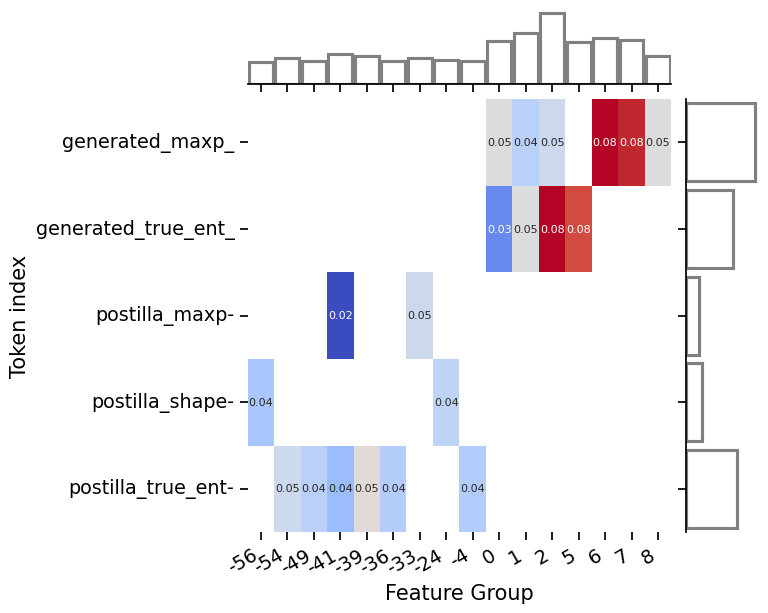

In [78]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":8}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [79]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [80]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.49      0.58      0.53       364
        True       0.48      0.40      0.44       364

    accuracy                           0.49       728
   macro avg       0.49      0.49      0.48       728
weighted avg       0.49      0.49      0.48       728

CPU times: user 13.7 s, sys: 5.98 s, total: 19.7 s
Wall time: 6.33 s


In [81]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

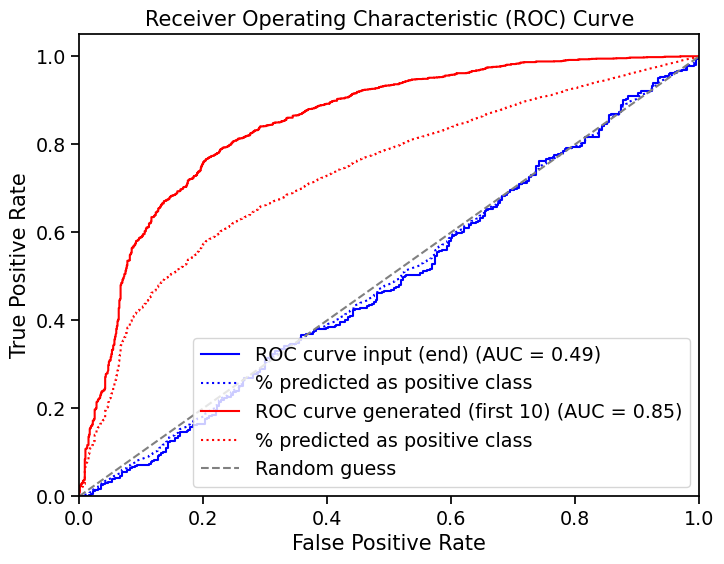

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba_generated[:, 1])
true_counts_rel = [(pred_proba_generated[:, 1] > thr).sum() / pred_proba_generated.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### does adding candidate distance measures add information?

In [83]:
# candidate measures are known at runtime and constant for each prompt

In [84]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [85]:
N = 2
#ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way?

In [86]:
# % of prompts showing variance in output across runs (selected features)
(ds.groupby('pid').std() != 0.).sum() / ds.pid.nunique()

run             1.0
maxp0           1.0
maxp1           1.0
maxp2           1.0
maxp3           1.0
               ... 
true_ent54      1.0
true_ent55      1.0
true_ent56      1.0
correct         1.0
hallucinated    1.0
Length: 117, dtype: float64

In [87]:
# WARNING only unique observations
ds = ds.drop_duplicates(ds.columns[1:-2])

In [88]:
ds.shape

(1476, 118)

In [89]:
ds.correct.value_counts()

correct
True     1112
False     364
Name: count, dtype: int64

In [90]:
# check variances

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)

In [91]:
X_res.shape

(1476, 116)

In [92]:
y_res.value_counts()

correct
True     1112
False     364
Name: count, dtype: int64

In [93]:
(X_res.groupby('pid').std() != 0.).sum() / X_res.pid.nunique()

maxp0         1.0
maxp1         1.0
maxp2         1.0
maxp3         1.0
maxp4         1.0
             ... 
true_ent53    1.0
true_ent54    1.0
true_ent55    1.0
true_ent56    1.0
correct       1.0
Length: 115, dtype: float64

In [94]:
# dataset 

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(1476, 114) 1112


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent47', 'generated_true_ent48', 'generated_true_ent49',
       'generated_true_ent50', 'generated_true_ent51', 'generated_true_ent52',
       'generated_true_ent53', 'generated_true_ent54', 'generated_true_ent55',
       'generated_true_ent56'],
      dtype='object', length=114)

In [95]:
X_res.shape, y_res.shape

((1476, 114), (1476,))

In [96]:
# class weights
class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

In [97]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.46      0.50      0.48       364
        True       0.83      0.80      0.82      1112

    accuracy                           0.73      1476
   macro avg       0.64      0.65      0.65      1476
weighted avg       0.74      0.73      0.73      1476

CPU times: user 19.1 s, sys: 8.42 s, total: 27.5 s
Wall time: 8.15 s


In [98]:
# dataset with candidate measures

add = aggrodue[['pid', 'cand_average_dist_mean', 'cand_max_dist_mean', 'cand_average_jaccard_dist_mean', 'cand_average_jaccard_tok_dist_mean']]
add = add.rename(columns={'cand_average_dist_mean': 'cand_average_dist_mean999', 
                          'cand_max_dist_mean': 'cand_max_dist_mean999', 
                          'cand_average_jaccard_dist_mean': 'cand_average_jaccard_dist_mean999',
                          'cand_average_jaccard_tok_dist_mean': 'cand_average_jaccard_tok_dist_mean999'})
ds_ = ds.merge(add, on='pid')

y = ds_.correct
pids = ds_.pid
X = ds_.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(1476, 118) 1112


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent51', 'generated_true_ent52', 'generated_true_ent53',
       'generated_true_ent54', 'generated_true_ent55', 'generated_true_ent56',
       'generated_cand_average_dist_mean999',
       'generated_cand_max_dist_mean999',
       'generated_cand_average_jaccard_dist_mean999',
       'generated_cand_average_jaccard_tok_dist_mean999'],
      dtype='object', length=118)

In [99]:
X_res.shape, y_res.shape

((1476, 118), (1476,))

In [100]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba2 = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred2 = pred_proba2.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred2))

              precision    recall  f1-score   support

       False       0.45      0.50      0.47       364
        True       0.83      0.80      0.82      1112

    accuracy                           0.73      1476
   macro avg       0.64      0.65      0.64      1476
weighted avg       0.74      0.73      0.73      1476

CPU times: user 16.7 s, sys: 6.41 s, total: 23.1 s
Wall time: 6.62 s


In [101]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100, booster='gblinear').fit(X_res, y_res, sample_weight=sample_weights)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [102]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (58) and will cycle, which may produce an uninterpretable plot.


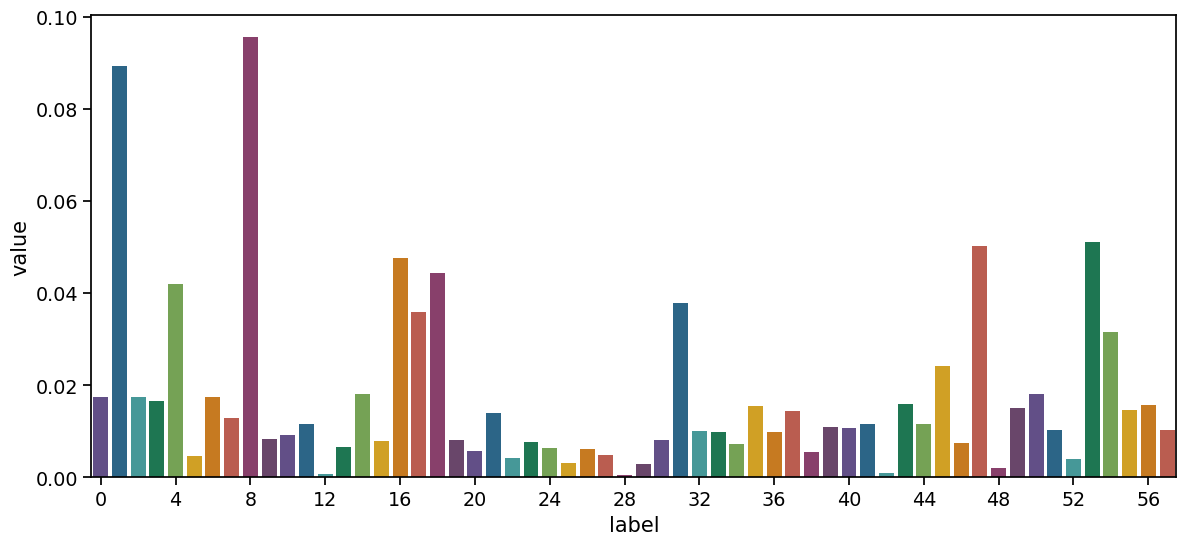

In [103]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

plt.figure(figsize=(14, 6))
ax = plt.gca()
sns.barplot(index_importances, palette=palette,ax=ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))

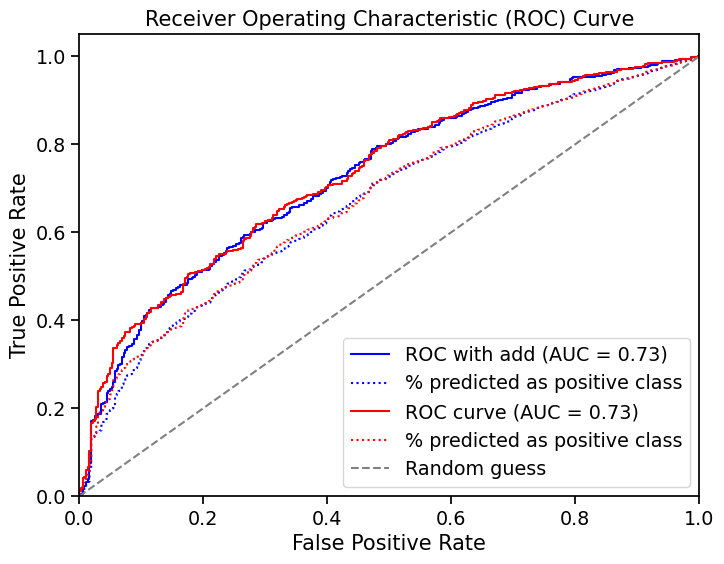

In [104]:
# compare with and without candidate measures

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba2[:, 1])
true_counts_rel = [(pred_proba2[:, 1] > thr).sum() / pred_proba2.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC with add (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### variable window: combo (postilla + generated)

In [284]:
ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()
ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [285]:
dss.shape

(1217522, 6)

In [286]:
%%time

outs_combo = []

for K in range(0, postilla_shift+mingen+1, 1):
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1) # randomism
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_combo.append((r, K, pred_proba, y_res))

CPU times: user 49min 33s, sys: 16min 14s, total: 1h 5min 47s
Wall time: 10min 6s


In [287]:
aucs = []
for r, K, pred_proba, y_res in outs_combo:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))

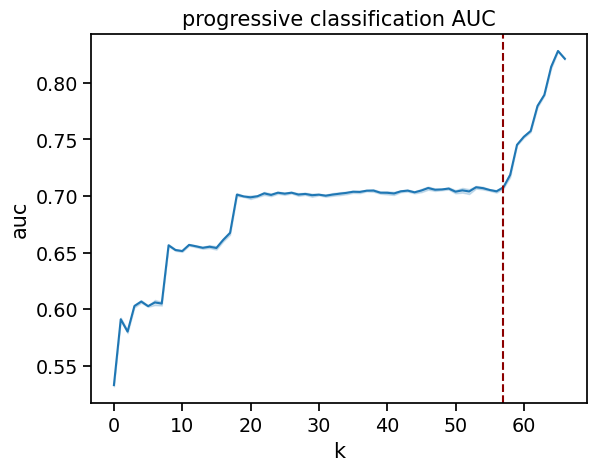

In [288]:
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

# postilla
ax = sns.lineplot(aucs_, x='k', y='auc')
ax.set_title("progressive classification AUC")
ax.axvline(postilla_shift + 1, color="darkred", linestyle="--", label="prompt end")

plt.show()

### variable window: postilla + generated + kl

In [301]:
selected_features = list(df_logitlens_kl_expanded.columns) + ['true_ent', 'maxp']

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [302]:
dss.shape

(1217522, 46)

In [303]:
ds1.shape, ds2.shape

((841890, 46), (375632, 46))

In [304]:
%%time

outs_generated_kl = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = ['true_ent', 'maxp'] + besties_layers

for K in range(0, postilla_shift+mingen+1, 1):
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl.append((r, K, pred_proba, y_res))

CPU times: user 3h 33min 20s, sys: 37min 51s, total: 4h 11min 12s
Wall time: 39min 26s


### kl only

In [313]:
selected_features = list(df_logitlens_kl_expanded.columns)

ds1 = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]
ds2 = mmg[(mmg.segment=='generated')][['run', 'pid', 'tokzero'] + selected_features]

mingen = mmg[(mmg.segment=='generated')].groupby('pid').tokzero.max().min()
postilla_shift = mmg[(mmg.segment=='postilla')].tokzero.max()

ds2.tokzero += postilla_shift + 1
dss = pd.concat([ds1, ds2]).copy()

In [ ]:
%%time

outs_generated_kl_only = []

besties_ = [b.replace('generated_', '') for b in besties]
besties_layers = list(set((['_'.join(b.split('_')[:-1]) for b in besties_])))

selected_features = besties_layers

for K in range(0, postilla_shift+mingen+1, 1):
    print(K, end='\r')
    ds = dss[(dss.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-1])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl_only.append((r, K, pred_proba, y_res))

In [305]:
# generated with entropy/maxp features

aucs = []
for r, K, pred_proba, y_res in outs_combo:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_1['src'] = 'entropy/maxp'


# generated adding kl
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_2['src'] = 'kl'

# generated with kl only
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl_only:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_3 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_3['src'] = 'kl_only'


# aucs_ = pd.concat([aucs_1, aucs_2], axis=1)

#from scipy.ndimage import gaussian_filter1d
#aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

#sns.lineplot(aucs_, x='k', y='auc').set_title("AUC generated 1>14")
#plt.show()

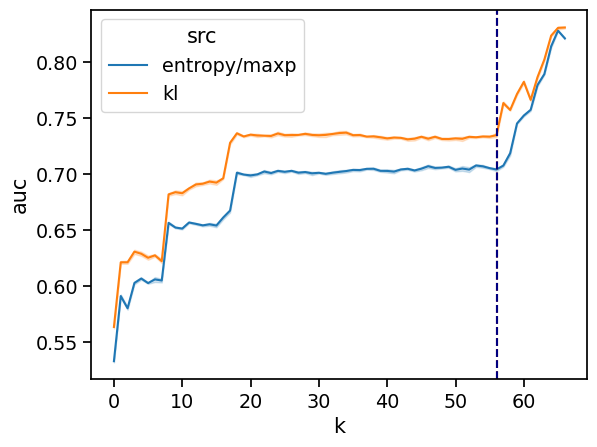

In [312]:
aucs_ = pd.concat([aucs_1, aucs_2, aucs_3], axis=0)

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

ax = sns.lineplot(aucs_, x='k', y='auc', hue='src')
ax.set_title("")

ax.axvline(postilla_shift, color="darkred", linestyle="--", label="prompt end")
# ax.axvline(postilla_shift + 10, color="navy", linestyle="--", label="prompt end")

plt.show()

### double check postilla with and without

In [307]:
%%time

selected_features = ['shape', 'true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla2_nokl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

(1652, 175)
CPU times: user 622 ms, sys: 156 ms, total: 778 ms
Wall time: 375 ms


In [308]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla2_nokl = cross_val_predict(xgb_model, X_res, y_res_postilla2_nokl, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 26 s, sys: 6.51 s, total: 32.5 s
Wall time: 4.75 s


In [309]:
%%time

selected_features = ['true_ent', 'maxp'] + besties_layers # + list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='postilla')][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-1])

print(ds.shape)

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla2_kl = y_res

X_res.columns = ['generated_'+col for col in X.columns]

(1652, 517)
CPU times: user 1.05 s, sys: 651 ms, total: 1.7 s
Wall time: 450 ms


In [310]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_postilla2_kl = cross_val_predict(xgb_model, X_res, y_res_postilla2_kl, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 1min 14s, sys: 11.8 s, total: 1min 26s
Wall time: 13.6 s


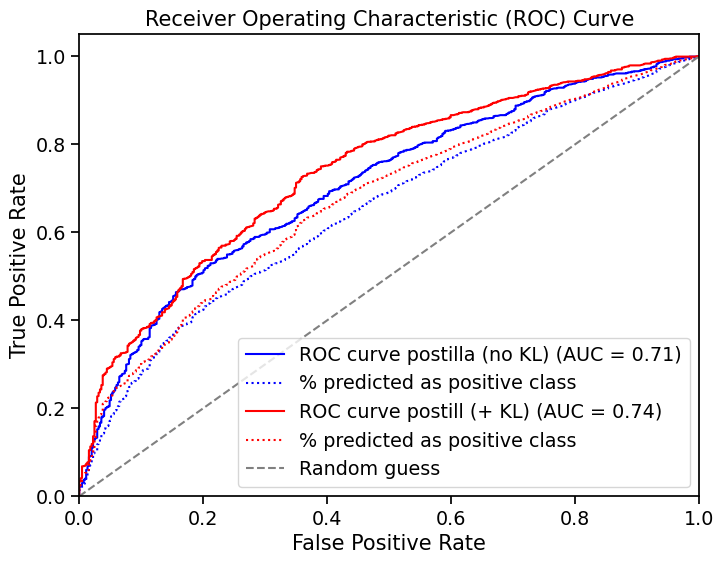

In [311]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla2_nokl.values, pred_proba_postilla2_nokl[:, 1])
true_counts_rel = [(pred_proba_postilla2_nokl[:, 1] > thr).sum() / pred_proba_postilla2_nokl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (no KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_postilla2_kl.values, pred_proba_postilla2_kl[:, 1])
true_counts_rel = [(pred_proba_postilla2_kl[:, 1] > thr).sum() / pred_proba_postilla2_kl.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve postill (+ KL) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [300]:
y_res_postilla2_kl.shape, y_res_postilla2_nokl.shape

((1652,), (1652,))